# Regression
Brian Li \
10/08/23

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal.lib
import pysal.model
import mgwr.gwr as gwr
import mgwr.sel_bw as sel_bw

This notebook contains regression analysis of CO2 per capita for countries across the globe in metric tons.

There are notably high levels of CO2 emissions per capita in East Asia.

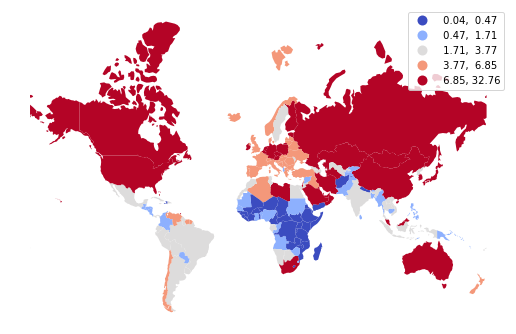

In [3]:
countries = gpd.read_file("https://michaelminn.net/tutorials/data/2019-world-energy-indicators.geojson")
countries = countries.to_crs("EPSG:3857")
plt.rcParams['figure.figsize'] = [9, 6]
axis = countries.plot("CO2_per_Capita_Tonnes", cmap = "coolwarm", legend=True, scheme="quantiles")
axis.set_axis_off()
plt.show()

In [4]:
countries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Country_Code                 175 non-null    object  
 1   Country_Name                 175 non-null    object  
 2   Longitude                    175 non-null    float64 
 3   Latitude                     175 non-null    float64 
 4   WB_Region                    171 non-null    object  
 5   WB_Income_Group              170 non-null    object  
 6   Population                   170 non-null    float64 
 7   GNI_PPP_B_Dollars            162 non-null    float64 
 8   GDP_per_Capita_PPP_Dollars   162 non-null    float64 
 9   MJ_per_Dollar_GDP            166 non-null    float64 
 10  Fuel_Percent_Exports         148 non-null    float64 
 11  Resource_Rent_Percent_GDP    168 non-null    float64 
 12  Exports_Percent_GDP          161 non-null    float64 
 1

The distribution of per capita CO2 emissions is skewed right.

The minimum for the data was 0.036 tonnes, the median was 2.482 tonnes, and the maximum was 32.762 tonnes.

The country with the highest per capita CO2 emissions in tonnes was Qatar, which makes sense because it is a very small country with a high dependence on fossil fuels.

The country with the lowest annual per capita CO2 emissions is the Democratic Republic of the Congo, which can be explained by the country's extremely low level of development, one of the lowest in the world by HDI.

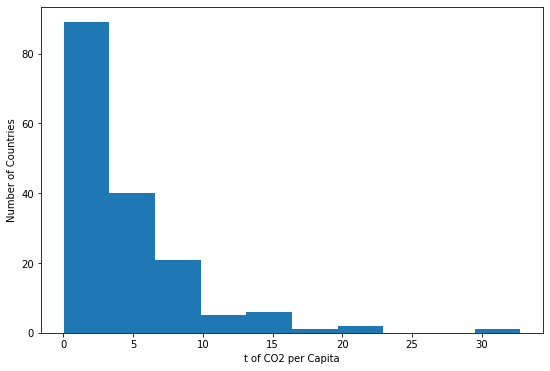

In [6]:
axis = plt.hist(countries["CO2_per_Capita_Tonnes"])
plt.xlabel("t of CO2 per Capita")
plt.ylabel("Number of Countries")
plt.show()

In [7]:
countries["CO2_per_Capita_Tonnes"].quantile([0, 0.25, 0.5, 0.75, 1.0])

0.00     0.036
0.25     0.690
0.50     2.482
0.75     5.611
1.00    32.762
Name: CO2_per_Capita_Tonnes, dtype: float64

In [8]:
data = countries[["Country_Name", "CO2_per_Capita_Tonnes"]]
data = data.dropna()
data = data.sort_values("CO2_per_Capita_Tonnes", ascending=False)
data = data.reset_index(drop=True)
print(data.head())

           Country_Name  CO2_per_Capita_Tonnes
0                 Qatar                 32.762
1                Kuwait                 20.862
2  United Arab Emirates                 20.502
3                  Oman                 16.518
4                Brunei                 15.957


In [9]:
print(data.tail())

             Country_Name  CO2_per_Capita_Tonnes
160                Malawi                  0.077
161               Burundi                  0.061
162  Central African Rep.                  0.046
163               Somalia                  0.043
164       Dem. Rep. Congo                  0.036


The variable that has the strongest correlation with the dependent variable is MM BTUs of energy used per capita, with a strong positive correlation and an R^2 value of 0.788.

These two variables are connected because countries that consume a lot of energy tend to be richer countries that emit more CO2 due to urban development and fossil fuel consumption.

One example of the post hoc fallacy that could follow from the correlation is that consuming more energy always leads to more CO2 emissions per capita.

One variable that has no correlation with the dependent variable is Population, which has an R^2 value of 0.

In [10]:
data = countries.select_dtypes(include=np.number)
r_squared = data.corr()["CO2_per_Capita_Tonnes"]**2
r_squared = r_squared.sort_values(ascending=False).round(3)
print(r_squared)

CO2_per_Capita_Tonnes          1.000
MM_BTU_per_Capita              0.788
GDP_per_Capita_PPP_Dollars     0.577
HDI                            0.413
Agriculture_Percent_GDP        0.293
Nuclear_Consumption_Quads      0.244
Nuclear_Production_Quads       0.244
Fuel_Percent_Exports           0.197
Oil_Production_Quads           0.181
Oil_Production_Mbd             0.173
Gas_Reserves_tcf               0.173
Industry_Percent_GDP           0.162
Gas_Production_Quads           0.152
Gas_Production_bcf             0.149
Oil_Reserves_B_Barrels         0.124
Gas_Consumption_Quads          0.123
Gas_Consumption_bcf            0.121
Latitude                       0.118
Gini_Index                     0.117
Exports_Percent_GDP            0.116
Military_Percent_GDP           0.113
Primary_Production_Quads       0.106
Oil_Consumption_Quads          0.081
Oil_Consumption_Mbd            0.079
Coal_Reserves_Mst              0.076
Renewable_Percent              0.071
Land_Area_sq_km                0.064
P

<AxesSubplot:xlabel='CO2_per_Capita_Tonnes', ylabel='MM_BTU_per_Capita'>

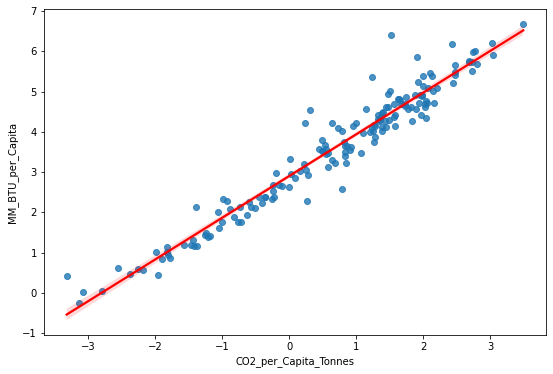

In [16]:
import seaborn as sns

data = countries[["CO2_per_Capita_Tonnes", "MM_BTU_per_Capita"]]
data = data.dropna()
data = np.log(data)
sns.regplot(x = "CO2_per_Capita_Tonnes", y = "MM_BTU_per_Capita", data=data, line_kws={"color": "red"})

<AxesSubplot:xlabel='CO2_per_Capita_Tonnes', ylabel='Population'>

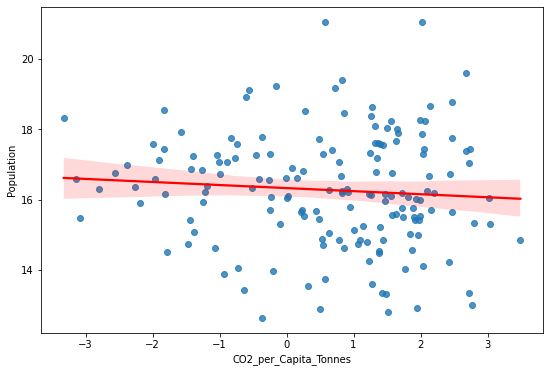

In [17]:
data = countries[["CO2_per_Capita_Tonnes", "Population"]]
data = data.dropna()
data = np.log(data)
sns.regplot(x = "CO2_per_Capita_Tonnes", y = "Population", data=data, line_kws={"color": "red"})

"One way to evaluate the influence of multiple factors on an effect is the use of multiple regression, which creates a model that considers multiple explanatory (independent) variables to predict the outcome of a response (dependent) variable" (https://michaelminn.net/tutorials/python-regression/).

My dependent variable is Metric Tons of CO2 produced per capita.

One independent variable I think may have influence on the dependent variable is GDP per Capita, because more developed countries will probably have more industry and things like personal cars and thus produce more CO2.

Another independent variable I chose was Industry Percent of GDP, since I figured industry tends to be pretty heavy in the CO2 department.

The third independent variable I chose was % energy produced by renewables, because the more renewables a country uses, the lower the CO2 produced.

The final independent variable was Gini Index, which has similar reasoning to HDI--poorer countries tend to have lower Gini coefficients, so this may have an influence as well.

In [28]:
dependent_name = ["CO2_per_Capita_Tonnes"]
independent_names = ["GDP_per_Capita_PPP_Dollars", "Renewable_Percent", "Industry_Percent_GDP", "Gini_Index"]
model_data = countries[dependent_name + independent_names + ["geometry", "Latitude", "Longitude"]]
model_data = model_data.dropna()

,CO2_per_Capita_Tonnes,GDP_per_Capita_PPP_Dollars,Renewable_Percent,Industry_Percent_GDP,Gini_Index,Latitude,Longitude
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,3.695878,22293.838659,18.978260,25.670504,37.247967,21.371439,18.433569
std,3.866630,22051.771587,17.169308,7.577067,7.979640,26.562708,56.797196
min,0.077000,1181.932000,0.190000,5.552000,23.200000,-39.047000,-112.599000
25%,0.691000,5316.808000,6.167000,20.177500,31.300000,6.047500,-3.580000
50%,2.361000,14407.366000,15.306000,25.184000,35.700000,18.884000,19.358000
75%,5.453500,33192.456000,26.518000,30.647500,41.750000,44.624500,35.295000
max,20.502000,120174.755000,82.766000,49.761000,63.000000,69.157000,167.074000


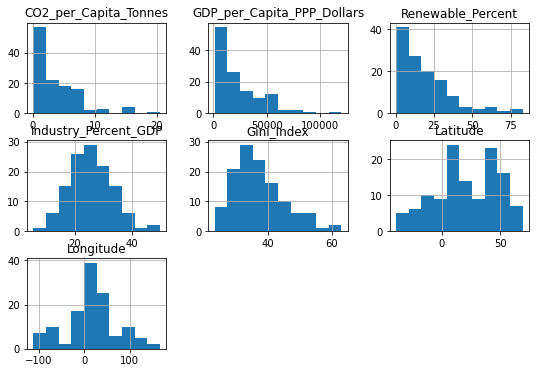

In [29]:
model_data.hist()
model_data.describe()

,CO2_per_Capita_Tonnes,GDP_per_Capita_PPP_Dollars,Renewable_Percent,Industry_Percent_GDP,Gini_Index,Latitude,Longitude
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,1.247033,9.451772,2.577287,25.670504,37.247967,21.371439,18.433569
std,0.778665,1.164057,1.023587,7.577067,7.979640,26.562708,56.797196
min,0.074179,7.075751,0.173953,5.552000,23.200000,-39.047000,-112.599000
25%,0.525320,8.578804,1.967616,20.177500,31.300000,6.047500,-3.580000
50%,1.212239,9.575564,2.791533,25.184000,35.700000,18.884000,19.358000
75%,1.864379,10.410101,3.314832,30.647500,41.750000,44.624500,35.295000
max,3.068146,11.696711,4.428027,49.761000,63.000000,69.157000,167.074000


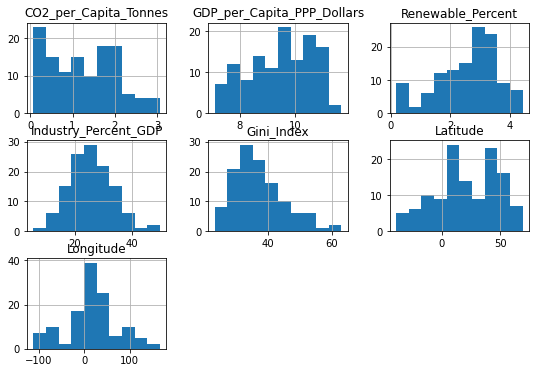

In [30]:
transform_vars = ["CO2_per_Capita_Tonnes", "GDP_per_Capita_PPP_Dollars", "Renewable_Percent"]
model_data[transform_vars] = np.log(model_data[transform_vars] + 1)
model_data.hist()
model_data.describe()

array([[<AxesSubplot:title={'center':'CO2_per_Capita_Tonnes'}>,
        <AxesSubplot:title={'center':'GDP_per_Capita_PPP_Dollars'}>,
        <AxesSubplot:title={'center':'Renewable_Percent'}>],
       [<AxesSubplot:title={'center':'Industry_Percent_GDP'}>,
        <AxesSubplot:title={'center':'Gini_Index'}>,
        <AxesSubplot:title={'center':'Latitude'}>],
       [<AxesSubplot:title={'center':'Longitude'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

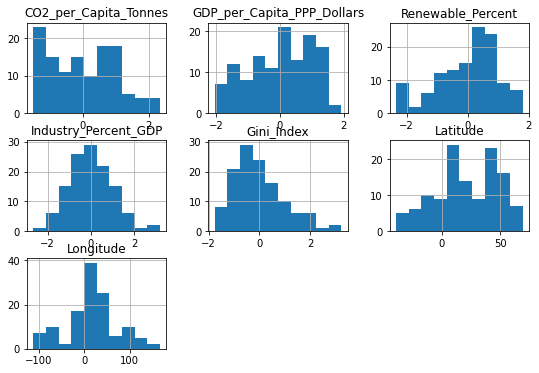

In [31]:
var_names = dependent_name + independent_names
model_data[var_names] = (model_data[var_names] - model_data[var_names].mean()) / model_data[var_names].std()
model_data.hist()

A R^2 value of 0.8642 indicates that 86.42% of variance in the dependent variable is explained by my model.

The variable that makes the most significant contribution to the model is GDP_per_Capita_PPP_Dollars, with a coefficient of 0.9152815.

The variable that makes the least significant contribution to the model is Gini_Index, with a coefficient of -0.0062143.

My model is unaffected by multi collinearity because all the VIFs are below 1.5.

In [32]:
ols_model = pysal.model.spreg.OLS(model_data[dependent_name].values, model_data[independent_names].values, name_y = dependent_name, name_x = independent_names)
print(ols_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :['CO2_per_Capita_Tonnes']                Number of Observations:         123
Mean dependent var  :      0.0000                Number of Variables   :           5
S.D. dependent var  :      1.0000                Degrees of Freedom    :         118
R-squared           :      0.8642
Adjusted R-squared  :      0.8596
Sum squared residual:      16.572                F-statistic           :    187.6683
Sigma-square        :       0.140                Prob(F-statistic)     :   3.668e-50
S.E. of regression  :       0.375                Log likelihood        :     -51.256
Sigma-square ML     :       0.135                Akaike info criterion :     112.512
S.E of regression ML:      0.3671                Schwarz criterion     :     126.573

----------------------------------------------------------------

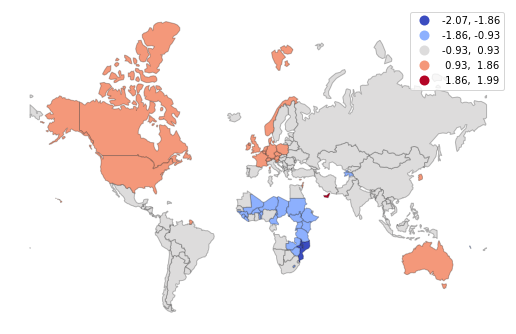

In [33]:
residuals = model_data
residuals["Residuals"] = ols_model.predy
axis = residuals.plot("Residuals", legend=True, cmap = "coolwarm", edgecolor = "#00000040", scheme="stdmean")
axis.set_axis_off()
plt.show()

In [34]:
pysal.model.spreg.vif(ols_model)

[None,
 (1.2000570248460356, 0.833293734627567),
 (1.0850102175819367, 0.9216503068778549),
 (1.0291503906063888, 0.9716752858741928),
 (1.2696410471471336, 0.7876241889366972)]

"Spatial regression models involve techniques that compensate for spatial autocorrelation so the model coefficients and outputs are more trustworthy" (https://michaelminn.net/tutorials/python-regression/).

My spatial lag model is the best, because it has the highest AIC value at 114.417 vs spatial regression with an AIC of 106.421 and non-spatial OLS with an AIC value of 112.512.

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


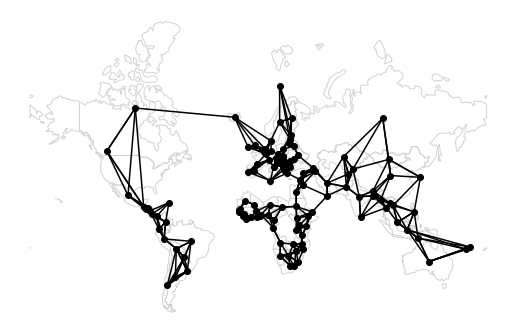

In [35]:
weights = pysal.lib.weights.KNN.from_dataframe(model_data, k=4)
axis = model_data.plot(edgecolor="lightgray", facecolor="none")
weights.plot(gdf=model_data, ax=axis)
axis.set_axis_off()
plt.show()

In [40]:
lag_model = pysal.model.spreg.ML_Lag(model_data[dependent_name].values, model_data[independent_names].values, weights)
print(lag_model.summary)

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         123
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0000                Degrees of Freedom    :         117
Pseudo R-squared    :      0.8643
Spatial Pseudo R-squared:  0.8634
Sigma-square ML     :       0.135                Log likelihood        :     -51.208
S.E of regression   :       0.367                Akaike info criterion :     114.417
                                                 Schwarz criterion     :     131.290

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [41]:
err_model = pysal.model.spreg.ML_Error(model_data[dependent_name].values, model_data[independent_names].values, weights)
print(err_model.summary)

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/scipy/optimize/_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         123
Mean dependent var  :      0.0000                Number of Variables   :           5
S.D. dependent var  :      1.0000                Degrees of Freedom    :         118
Pseudo R-squared    :      0.8632
Sigma-square ML     :       0.126                Log likelihood        :     -48.210
S.E of regression   :       0.354                Akaike info criterion :     106.421
                                                 Schwarz criterion     :     120.482

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------